In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
import skimage.exposure
import pandas as pd
%load_ext autoreload
%autoreload 2

In [6]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK39'
INPUT = os.path.join(DIR, 'preps', 'CH2', 'full')
CLEANED = os.path.join(DIR, 'preps', 'CH1', 'thumbnail_cleaned')
files = sorted(os.listdir(INPUT))

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import fix_with_blob, scaled, linnorm, fix_with_fill, fix_with_fill_debug

Connecting dklab@192.168.1.12:3306


In [ ]:
bad43 = [91,122,138,232,233,234,235,236,237,238,239,275,277,295,296,299,313,333,350,356,357,381]
bads = ['{}.tif'.format(str(i).zfill(3)) for i in bad43]

100%|██████████| 5/5 [00:35<00:00,  7.03s/it]


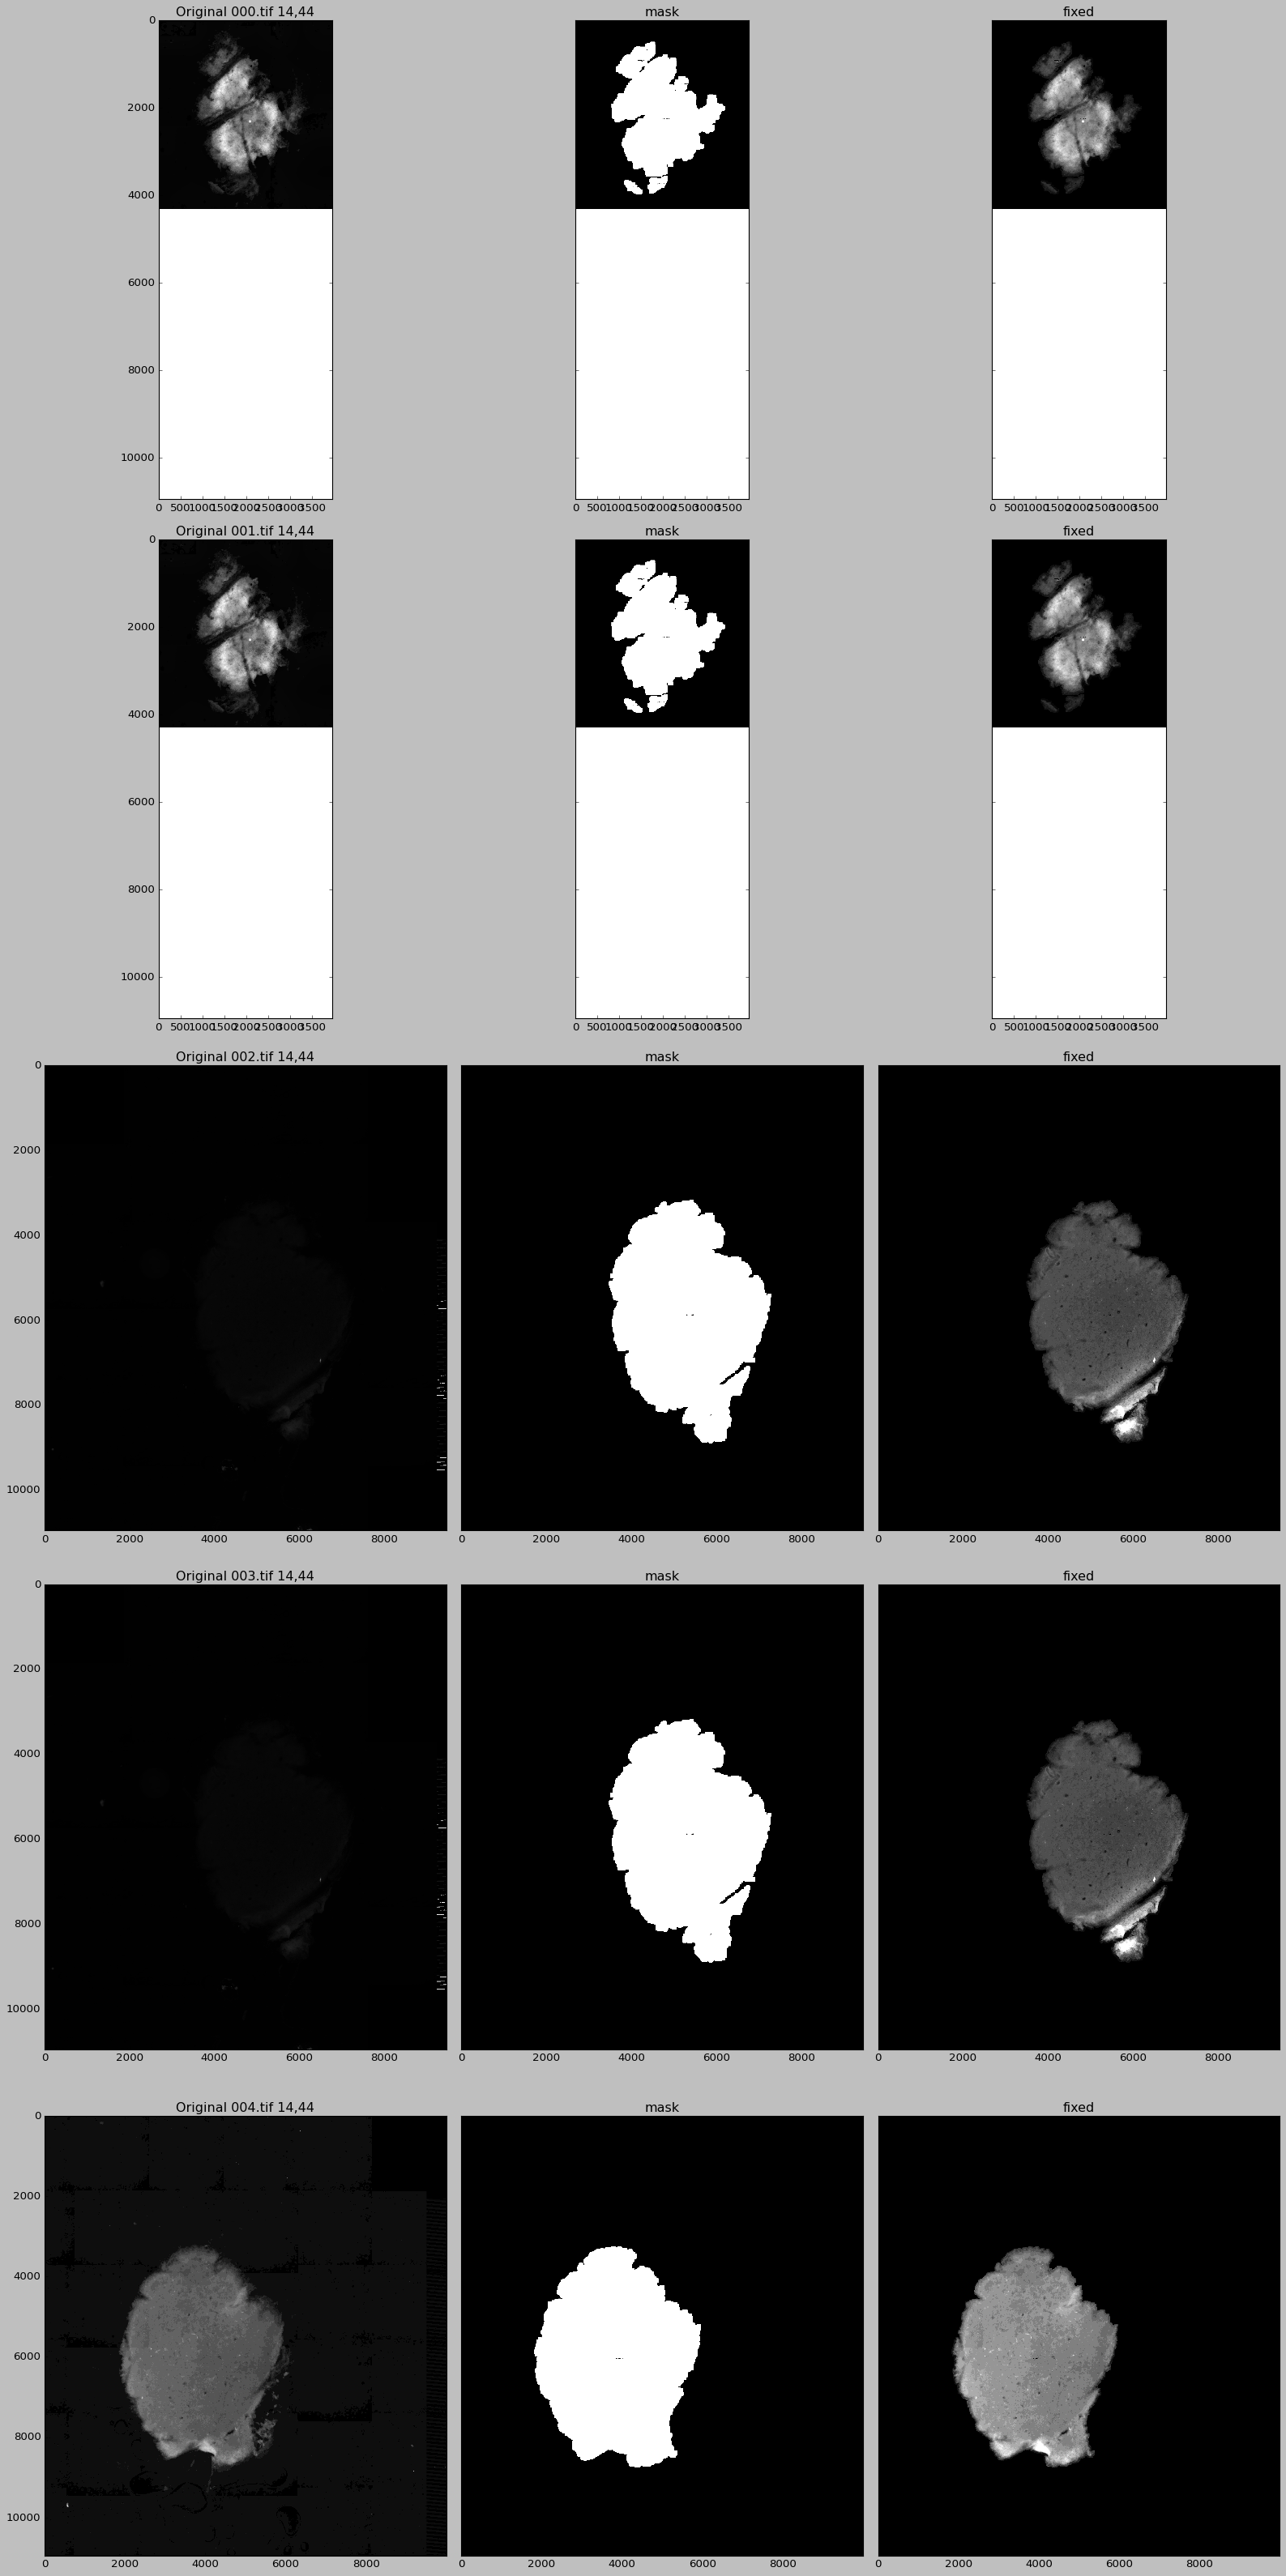

In [7]:
img_inputs = []
titles = []
masks = []
img_outputs = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
start, finish = (132,152)

for file in tqdm(files):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    mask, threshold = fix_with_fill_debug(img)
    fixed = cv2.bitwise_and(img, img, mask=mask)
    fixed = scaled(fixed, mask)    
    normed = clahe.apply(img)
    name = '{} {}'.format(file, threshold)
    
    img_inputs.append(normed)
    titles.append(name)        
    masks.append(mask)
    img_outputs.append(fixed)

fig, ax = plt.subplots(nrows=len(masks), ncols=3, sharex=False, sharey=True)
plt.style.use('classic')
i = 0
for filein, name, mask, fileout in zip(img_inputs, titles, masks, img_outputs):
    ax[i,0].set_title('Original {}'.format(name))
    ax[i,0].imshow(filein, cmap="gray")
    ax[i,1].set_title('mask')
    ax[i,1].imshow(mask, cmap="gray")
    ax[i,2].set_title('fixed')
    ax[i,2].imshow(fileout, cmap="gray")

    i += 1
# swap the 10 and the six below if the images are wider than height
fig.set_size_inches(np.array([20, 8 * len(masks)]), forward=False)
plt.tight_layout()
plt.show()